# Quick Start

In [1]:
# this cell's metadata contains
# "nbsphinx": "hidden" so it is hidden by nbsphinx
PATH_YIELD_ENGINE = 'src'
def set_paths() -> None:
    import sys
    import os
    
    if 'cwd' not in globals():
        global cwd
        cwd = os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir)
        os.chdir(cwd)   
    print(f"working dir is '{os.getcwd()}'")                            
    if PATH_YIELD_ENGINE not in sys.path:
        sys.path.insert(0, PATH_YIELD_ENGINE)
    print(f"added `{sys.path[0]}` to python paths")
set_paths()

working dir is 'C:\Users\martin florent\Documents\projects\yield-engine'
added `src` to python paths


The **gamma** package allows to

- build data science pipelines that follow scikit-learn API and are compatible with pandas dataframe
- select relevant features
- inspect the trained models
- visualize the results of the inspection

We first import the needed packages

In [2]:
import pandas as pd
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

from gamma import Sample
from gamma.viz.dendrogram import DendrogramDrawer, FeatMapStyle, LineStyle
from gamma.sklearndf.pipeline import PipelineDF, ModelPipelineDF
from gamma.sklearndf.transformation import SimpleImputerDF, MissingIndicatorDF
from gamma.sklearndf.transformation.extra import BorutaDF
from gamma.sklearndf.regression import RandomForestRegressorDF, LGBMRegressorDF
from gamma.model.inspection import ModelInspector
from gamma.model.prediction import PredictorFitCV
from gamma.model.selection import ModelGrid, ModelRanker, summary_report
from gamma.model.validation import CircularCrossValidator
from gamma.yieldengine.simulation import UnivariateSimulator
from gamma.yieldengine.partition import ContinuousRangePartitioning
from gamma.yieldengine.viz import SimulationDrawer, SimulationPlotStyle

We load the Ames housing dataset: a regression problem on house prices.

In [3]:
df = pd.read_csv('data/ames-housing-dataset/train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df = df.drop(['Id', 'YrSold', 'MoSold'], axis=1)
TARGET = "SalePrice"
num_features = df.select_dtypes('number').columns
df = df[list(num_features)]

In [5]:
sample = Sample(observations=df, target_name=TARGET)

In [6]:
sample.features.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,2003.0,2,548,0,61,0,0,0,0,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,1976.0,2,460,298,0,0,0,0,0,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,2001.0,2,608,0,42,0,0,0,0,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,1998.0,3,642,0,35,272,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,2000.0,3,836,192,84,0,0,0,0,0


In [7]:
sample.target.head()

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

## Dataframes with scikit-learn

Scikit-learn works by default with numpy arrays: if one uses a scikit-learn transformer with a dataframe as input, one gets a numpy array as output. This can a problem since column names play a key role in the model inspection. 

In [8]:
imputed_array = SimpleImputer().fit_transform(sample.features)

In [9]:
imputed_array

array([[   60.,    65.,  8450., ...,     0.,     0.,     0.],
       [   20.,    80.,  9600., ...,     0.,     0.,     0.],
       [   60.,    68., 11250., ...,     0.,     0.,     0.],
       ...,
       [   70.,    66.,  9042., ...,     0.,     0.,  2500.],
       [   20.,    68.,  9717., ...,     0.,     0.,     0.],
       [   20.,    75.,  9937., ...,     0.,     0.,     0.]])

In [10]:
imputed_df = SimpleImputerDF().fit_transform(sample.features)

In [11]:
imputed_df.head()

column_out,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,2003.0,2.0,548.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,1976.0,2.0,460.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,2001.0,2.0,608.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,...,1998.0,3.0,642.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,2000.0,3.0,836.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0


In [12]:
sample_imputed = SimpleImputerDF().fit_transform_sample(sample=sample)

## Pipeline, cross validation and model selection

In [13]:
rf_pipeline = ModelPipelineDF(predictor=RandomForestRegressorDF(random_state=0), preprocessing=SimpleImputerDF())
lgbm_pipeline = ModelPipelineDF(predictor=LGBMRegressorDF(random_state=0), preprocessing=SimpleImputerDF())

In [14]:
grids = [ModelGrid(pipeline=rf_pipeline, predictor_parameters={"n_estimators": [10, 20]}),
         ModelGrid(pipeline=lgbm_pipeline, predictor_parameters={"learning_rate": [0.1, 0.2]})]

In [15]:
circular_cv = CircularCrossValidator(test_ratio=1/3, num_splits=3)
ranker = ModelRanker(grids=grids, cv=circular_cv)
ranking = ranker.run(sample_imputed, n_jobs=-3)
print(summary_report(ranking))

Rank  1:         LGBMRegressorDF, Score=    0.838, test_score_mean=    0.863, test_score_std=   0.0123, , Parameters={predictor__learning_rate=0.2}

Rank  2:         LGBMRegressorDF, Score=    0.833, test_score_mean=    0.869, test_score_std=   0.0176, , Parameters={predictor__learning_rate=0.1}

Rank  3: RandomForestRegressorDF, Score=    0.813, test_score_mean=    0.854, test_score_std=   0.0208, , Parameters={predictor__n_estimators=20}

Rank  4: RandomForestRegressorDF, Score=    0.789, test_score_mean=    0.839, test_score_std=   0.0249, , Parameters={predictor__n_estimators=10}



## Model inspection

The champion model can be inspected consistently with the cross-valdiation strategy.
We first retrieve the champion model:

In [16]:
top_model = ranking[0]

In [17]:
predictor = PredictorFitCV(model=top_model.model, cv=circular_cv, sample=sample_imputed)

In [18]:
inspector = ModelInspector(predictor)
predictions = predictor.predictions_for_all_splits()

In [19]:
inspector.feature_importances().head()

column_out
OverallQual    0.295644
GrLivArea      0.137491
TotalBsmtSF    0.067399
BsmtFinSF1     0.058071
YearBuilt      0.057572
dtype: float64

### Shap clustering

Shap clustering is a method to cluster the features using the correlation matrix of the shap values.
Then using hierarchical clustering, and visualization style defined in the **gamma** package, one can easily visualize the clustering of the features.

In [20]:
linkage_tree = inspector.cluster_dependent_features()

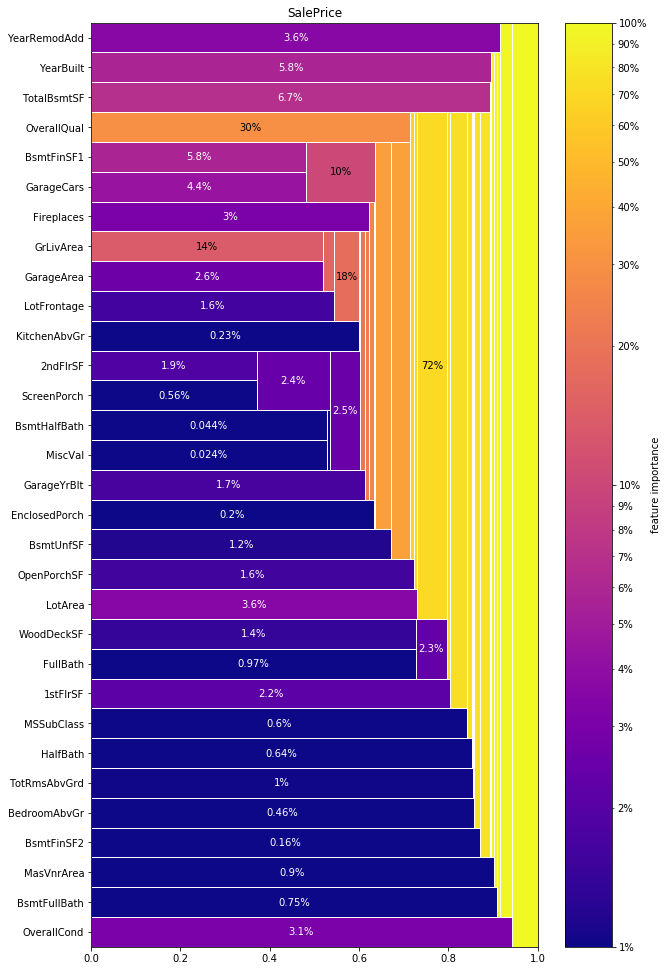

In [21]:
number_features = predictor.sample.features.shape[1]
ax = plt.figure(figsize=(10, number_features*.5)).add_subplot(111)
style = FeatMapStyle(ax)
DendrogramDrawer(title=TARGET, linkage_tree=linkage_tree, style=style).draw()

## Simulation

In [22]:
model_fit = inspector.model_fit
simulator = UnivariateSimulator(model_fit=model_fit)

In [23]:
feature = "GrLivArea"
partition = ContinuousRangePartitioning(values=model_fit.sample.features[feature])

In [24]:
univariate_simulation = simulator.simulate_feature(feature_name=feature, partitioning=partition)

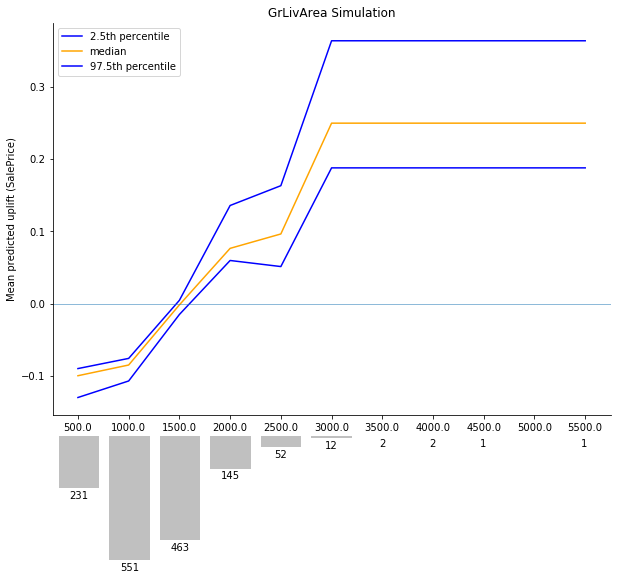

In [25]:
ax = plt.figure(figsize=(10,10)).add_subplot(111)
style = SimulationPlotStyle(ax)
drawer = SimulationDrawer(title=f"{feature} Simulation", simulation=univariate_simulation, style=style)
drawer.draw()